In [1]:
%matplotlib

Using matplotlib backend: <object object at 0x10625a350>


In [2]:
import mne
from pprint import pprint
import csv
import numpy as np
import pandas as pd
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [3]:
data_path = '/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/'

cntFile = data_path + 'S007_Alice_S001_new_2nd.cnt' #'S001_Alice.cnt'  
'''
S001_Alice.cnt: 最外圈的（編號尾數7的）沒有很毛，所以不exclude
'''

raw = mne.io.read_raw_cnt(cntFile)
raw.load_data()
raw.plot()
print(raw.info)
print(raw.info["ch_names"])

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_41857/2792904586.py:8: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cntFile)


Reading 0 ... 942719  =      0.000 ...   942.719 secs...
Using qt as 2D backend.
Opening raw-browser...


qt.qpa.drawing: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK


Using pyopengl with version 3.1.6
<Info | 9 non-empty values
 bads: 1 items (Audio)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 67 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO', 'Audio']


In [4]:
# filter and exclude certain channels
n_raw = raw.copy()
n_raw.resample(sfreq = 250)
n_raw.filter(0.1, 30, phase= 'zero-double')  # 再加0.1~30** / 1~30(訊號被扭曲的機率會更大) ，再重跑ICA
n_raw.set_eeg_reference(['M1', 'M2'])
n_raw.pick_types(eeg = True, stim = False, exclude = ['M1', 'M2', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO', 'Audio'])
                                                     # 'VEO', 'HEO', 'Audio' >> new layouts  #'HEOG', 'VEOG'
n_raw.plot()

# remove dc-offset

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Opening raw-browser...
Using pyopengl with version 3.1.6


Fitting ICA to data using 57 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 13.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components


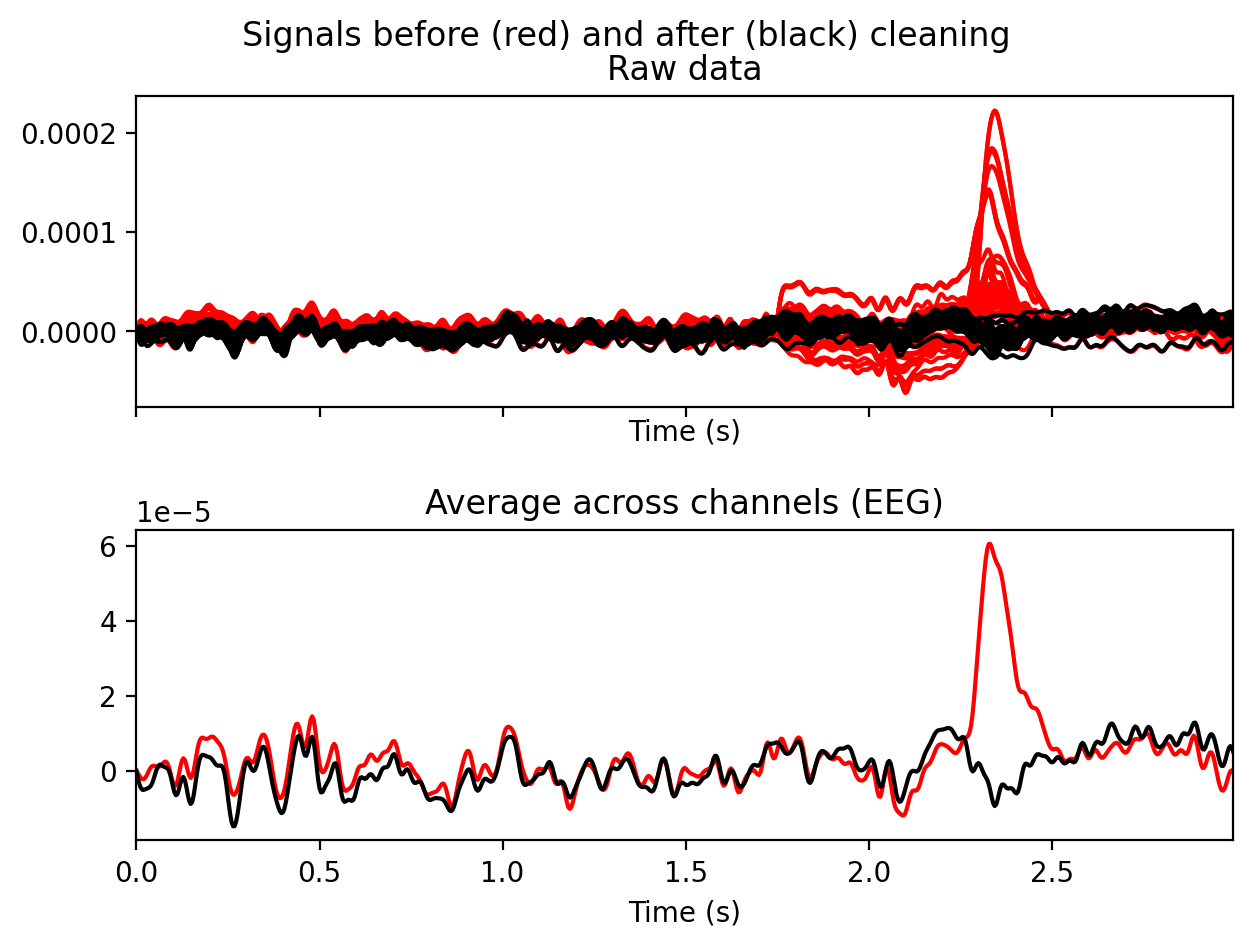

Closing raw-browser...
Channels marked as bad:
none
Closing raw-browser...
Channels marked as bad:
['Audio']


In [5]:
## WE NEED TO USE THE CUT FILE TO PERFORM ICA!!!

# set montage????? yes!!!
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
n_raw.set_montage(ten_twenty_montage, match_case=False)

# ICA
ica_ = ICA(n_components = 15, random_state=97)
ica_.fit(n_raw)

# plot ICA
#n_raw.plot_sensors(sphere = (0.0, 0.02, 0.0, 0.065))

# Exclude certain components
"""
S001:[0,5]  # DONE
S002:[0, 1, 3, 8, 10] #DONE
S003:[0,8,14] # DONE
S004-2:[0, 1, 3, 4, 6] #DONE
S005:[0, 1, 2, 8] #DONE
S006:[0,2]  #DONE >> adjust the filter range from 0-30 to 0.1-30
S007:[0,2]  #DONE >> adjust the filter range from 0-30 to 0.1-30
S008:[0,1,6,(7)]
"""

#ica_.plot_sources(n_raw)
#ica_.plot_components(sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
ica_.plot_overlay(n_raw, exclude=[0,2])

In [15]:
for i in range(15):
    #ica_.plot_properties(n_raw, picks=[i])
    ica_.plot_overlay(n_raw, exclude=[i])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 I

In [6]:
#### What the hack is this?????

# This is the properties of each component
#ica_.plot_properties(n_raw, picks=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# apply the cleaned ICA to the data 
ica_.exclude = [0,2]

raw_ICAed = n_raw.copy()
ica_.apply(raw_ICAed)
raw_ICAed.plot()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components
Opening raw-browser...
Using pyopengl with version 3.1.6


Closing raw-browser...
Channels marked as bad:
none


In [90]:
# List out the triggers #the starting and ending time point for each tape #時間要除以1000=事件發生的時間點
events = mne.events_from_annotations(raw_ICAed)
#print(events)

# covert the time points arrays into a list >> or is it better if we use it as the array??
trigger_tPointsNDArray = events[0]  #.tolist()
#print(trigger_tPointsNDArray)  

"""
dict.keys()
dict.values()
dict.items()
"""
triggerLIST = list(range(1,13))
#print(triggerLIST)

trigger_nameDICT = events[1]
triggerkey = trigger_nameDICT.keys()

# trigger_nameDICT.keys()    # the actual number mark I made for trigger
#print(trigger_nameDICT.values())  # 1-25

print(trigger_nameDICT)
print(trigger_tPointsNDArray)

start_tNDarray = trigger_tPointsNDArray[::4]
print(start_tNDarray)
print(type(start_tNDarray))
end_tNDarray = trigger_tPointsNDArray[1::4]
print(end_tNDarray)
print(type(end_tNDarray))
"""
# Change the arranged marks into slef-defined marks, and collect the start & end timepoints in seperate ndarray
for v in trigger_nameDICT:
        print(v)
        for t_Array in trigger_tPointsNDArray:
            print(t_Array[2])
            if t_Array[2] == v:    # if t_Array[2] == k's value
                print("YES, FOUND IT!")
                #print(t_Array[2])
                # Change the arranged marks into slef-defined marks
                #print("arranged marks = ", t_Array[2])
                #print("new trigger = ", trigger_tPointsNDArray[v])
            
        #t_Array[2] = k 
            else:
                pass
"""
"""
#print(trigger_tPointsNDArray)
#trigger_tPointsNDArray.shape  #(48, 3)

#start_tNDarray = np.nd
#start_tNDarray = trigger_tPointsNDArray[::4]
#print(start_tNDarray)

#for i in range(12):
    #start_tNDarray = trigger_tPointsNDArray[i::4]
    #print(start_tNDarray)
    #end_tNDarray = trigger_tPointsNDArray[i+2::4]
"""


Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '7', '8', '9', '99']
{'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '50': 9, '51': 10, '52': 11, '53': 12, '54': 13, '55': 14, '56': 15, '57': 16, '58': 17, '59': 18, '6': 19, '60': 20, '61': 21, '7': 22, '8': 23, '9': 24, '99': 25}
[[  6572      0      1]
 [ 21075      0     25]
 [ 21203      0      9]
 [ 25471      0     25]
 [ 25738      0      5]
 [ 40991      0     25]
 [ 41119      0     10]
 [ 43688      0     25]
 [ 44733      0      6]
 [ 60736      0     25]
 [ 60863      0     11]
 [ 64609      0     25]
 [ 64995      0      7]
 [ 82498      0     25]
 [ 82626      0     12]
 [ 84538      0     25]
 [ 84917      0      8]
 [101670      0     25]
 [101798      0     13]
 [105617      0     25]
 [105998      0     19]
 [122001      0     25]
 [122128      0     14]
 [125646      0     25]
 [126020      0   

'\n#print(trigger_tPointsNDArray)\n#trigger_tPointsNDArray.shape  #(48, 3)\n\n#start_tNDarray = np.nd\n#start_tNDarray = trigger_tPointsNDArray[::4]\n#print(start_tNDarray)\n\n#for i in range(12):\n    #start_tNDarray = trigger_tPointsNDArray[i::4]\n    #print(start_tNDarray)\n    #end_tNDarray = trigger_tPointsNDArray[i+2::4]\n'

In [40]:
def correct_time(Start_timeFLOAT, End_timeFLOAT, stim_onsetFLOAT):
    actual_timeFLOAT = stim_onsetFLOAT*(End_timeFLOAT-Start_timeFLOAT)+(Start_timeFLOAT)
    return actual_timeFLOAT

In [ ]:
# Use the event id >> should segment the data first??
event_id = {'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '99': 13}
#{'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '99': 13}
                                        # state which conditions match with which triggers #

# each epoch would be 300 ms long 
# >> start_timepoint = each onset, end_timepoint = onset + 0.3
# need to recalibrate the starting time point in every part of 
tmin = -0.5                                         # pre stimulis interval (in seconds) #
tmax = 1.0                                          # post stimulus interval #

picks = mne.pick_types(raw_.info, eeg= True, stim = False)    # channels to use in epochs #
baseline = (-0.1, 0)      
reject_ = dict(eeg=100e-6) # eeg: V, meg: T                                                       # what to use as baseline comparison - here it's pre-stim interval #
epochs = mne.Epochs(raw_clean, new_events, event_id, tmin, tmax, proj = True,
                    picks = picks, baseline=baseline,
                    reject = reject_, preload = True)

In [ ]:
std_evoked = epochs['Standard (yi3)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devL_evoked = epochs['Large deviant (yi1)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devS_evoked = epochs['Small deviant (yi2)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)

print(std_evoked)
print(devL_evoked)
print(devS_evoked)

In [ ]:
tmp = [std_evoked, devL_evoked, devS_evoked]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')